In [1]:
from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [3]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [4]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y


#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


"""def dice_coef(y_true, y_pred, smooth=1):

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)"""



def weighted_binary_crossentropy(y_true, y_pred):
        # Calculate the binary crossentropy
    b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70
    weighted_b_ce = weight_vector * b_ce

        # Return the mean error
    return K.mean(weighted_b_ce)


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)


#Override Dropout. Make it able at test time.
def call(self, inputs, training=None):
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [20]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    #conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(0.3)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(0.3)(pool2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(0.3)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(0.3)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(0.3)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(0.3)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(0.3)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    #model = Model(input=inputs, output=conv10)
    model = Model(outputs=conv10, inputs=inputs)

    #model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    #model.compile(optimizer=Adam(lr=1e-3), loss=losses.binary_crossentropy, metrics = [dice_coef])
    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model



## Constants

In [33]:
data_path = '../data/'
param_path = '/home/malub_local/'


path_img_train = data_path + 'images_69.npy'
path_mask_train = data_path + 'masks_69.npy'

path_img_valid = data_path + 'images_valid_29.npy'
path_mask_valid = data_path + 'masks_valid_29.npy'

# PATH definition
initial_weights_path = "./models/initial_weights.hdf5"
final_weights_path = "./models/model_intermediate.hdf5"


# image dimension (array)
img_rows = 512
img_cols = 512

batch_size = 12



fill_mode = 'reflect'
rotation_range= 20
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.2
channel_shift_range = 0.1
width_shift_range = 0.2
height_shift_range = 0.2


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

nb_initial_epochs = 300
apply_augmentation = True
nb_step_predictions = 20
steps_per_epoch = 30

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs


apply_edt = False



In [34]:
def save_parameters(timestamp, params):
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params():
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict

### Data pre processing

In [8]:
X_train, y_train = load_data(path_img_train, path_mask_train, img_rows, img_cols )
print("*************Xtrain.shape***********", y_train.shape)


X_valid, y_valid = load_data(path_img_valid, path_mask_valid, img_rows, img_cols)
print("*************Xvalid.shape***********", X_valid.shape)

X_valid = X_valid[:-2]
y_valid = y_valid[:-2]

X_test = X_valid[-2:]
y_test = y_valid[-2:]

print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)
print(X_test.shape)



Loading data...

*************Xtrain.shape*********** (69, 1, 512, 512)

Loading data...

*************Xvalid.shape*********** (29, 1, 512, 512)
(27, 1, 512, 512) (27, 1, 512, 512) (2, 1, 512, 512) (2, 1, 512, 512)
(2, 1, 512, 512)


### Data Augmentation

In [22]:
# data augmentation
seed = 1

train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)

train_generator = zip(train_img_generator, train_mask_generator)



## Training

In [36]:
model = unet_full_bn(dropout = True)
reset_weights(model)
print(model.summary())



model_checkpoint = ModelCheckpoint(initial_weights_path, monitor='loss', save_best_only = True)


# if Data Augmentation
if apply_augmentation:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params())
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit_generator(train_generator, 
                                  validation_data = (X_valid, y_valid),
                                  epochs = nb_initial_epochs, 
                                  verbose = 1,
                                  shuffle = True,
                                  steps_per_epoch = steps_per_epoch, 
                                  #validation_steps= 5,
                                  callbacks = [tensorboard ])
    model.save(final_weights_path)

    
# if No Data Augmentation
else:
    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(format(time.strftime('%m%d_%H%M_%S')), get_params())
    tensorboard = TensorBoard(log_dir = str("../logs/" + str(timestamp)))
    history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid),
                            batch_size = batch_size, 
                            epochs = nb_initial_epochs,
                            verbose = 1, 
                            shuffle = True, 
                            callbacks = [tensorboard])
    model.save(final_weights_path)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 1, 512, 512)  0                                            
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 32, 512, 512) 320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 32, 512, 512) 9248        conv2d_153[0][0]                 
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 32, 512, 512) 128         conv2d_154[0][0]                 
__________________________________________________________________________________________________
max_poolin

Epoch 1/300
30/30 [==============================] - 19s 640ms/step - loss: 0.2715 - dice_coef: 0.6248 - val_loss: 1.6644 - val_dice_coef: 0.3784
Epoch 2/300
30/30 [==============================] - 18s 610ms/step - loss: 0.2308 - dice_coef: 0.6449 - val_loss: 0.3213 - val_dice_coef: 0.3954
Epoch 3/300
30/30 [==============================] - 18s 609ms/step - loss: 0.2151 - dice_coef: 0.6466 - val_loss: 0.2371 - val_dice_coef: 0.3030
Epoch 4/300
30/30 [==============================] - 18s 608ms/step - loss: 0.2076 - dice_coef: 0.6433 - val_loss: 0.1757 - val_dice_coef: 0.4777
Epoch 5/300
30/30 [==============================] - 18s 608ms/step - loss: 0.2012 - dice_coef: 0.6417 - val_loss: 0.1690 - val_dice_coef: 0.5967
Epoch 6/300
30/30 [==============================] - 18s 608ms/step - loss: 0.1951 - dice_coef: 0.6465 - val_loss: 0.1662 - val_dice_coef: 0.5960
Epoch 7/300
30/30 [==============================] - 18s 609ms/step - loss: 0.1934 - dice_coef: 0.6496 - val_loss: 0.1785 - 

Epoch 57/300
30/30 [==============================] - 18s 609ms/step - loss: 0.1369 - dice_coef: 0.7814 - val_loss: 0.1576 - val_dice_coef: 0.7054
Epoch 58/300
30/30 [==============================] - 18s 610ms/step - loss: 0.1359 - dice_coef: 0.7820 - val_loss: 0.1588 - val_dice_coef: 0.6988
Epoch 59/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1336 - dice_coef: 0.7885 - val_loss: 0.1447 - val_dice_coef: 0.6887
Epoch 60/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1351 - dice_coef: 0.7862 - val_loss: 0.1531 - val_dice_coef: 0.6720
Epoch 61/300
30/30 [==============================] - 18s 612ms/step - loss: 0.1339 - dice_coef: 0.7885 - val_loss: 0.1568 - val_dice_coef: 0.7104
Epoch 62/300
30/30 [==============================] - 18s 613ms/step - loss: 0.1333 - dice_coef: 0.7878 - val_loss: 0.1568 - val_dice_coef: 0.7114
Epoch 63/300
30/30 [==============================] - 18s 612ms/step - loss: 0.1331 - dice_coef: 0.7878 - val_loss: 0.

30/30 [==============================] - 18s 612ms/step - loss: 0.1205 - dice_coef: 0.8200 - val_loss: 0.1582 - val_dice_coef: 0.7009
Epoch 113/300
30/30 [==============================] - 18s 614ms/step - loss: 0.1190 - dice_coef: 0.8195 - val_loss: 0.1644 - val_dice_coef: 0.7158
Epoch 114/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1201 - dice_coef: 0.8219 - val_loss: 0.1675 - val_dice_coef: 0.7230
Epoch 115/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1212 - dice_coef: 0.8195 - val_loss: 0.1548 - val_dice_coef: 0.7247
Epoch 116/300
30/30 [==============================] - 18s 612ms/step - loss: 0.1186 - dice_coef: 0.8226 - val_loss: 0.1649 - val_dice_coef: 0.7036
Epoch 117/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1170 - dice_coef: 0.8224 - val_loss: 0.1663 - val_dice_coef: 0.7082
Epoch 118/300
30/30 [==============================] - 18s 612ms/step - loss: 0.1184 - dice_coef: 0.8237 - val_loss: 0.1549 - 

30/30 [==============================] - 18s 609ms/step - loss: 0.1070 - dice_coef: 0.8378 - val_loss: 0.1788 - val_dice_coef: 0.7255
Epoch 168/300
30/30 [==============================] - 18s 610ms/step - loss: 0.1139 - dice_coef: 0.8355 - val_loss: 0.1634 - val_dice_coef: 0.7094
Epoch 169/300
30/30 [==============================] - 18s 608ms/step - loss: 0.1097 - dice_coef: 0.8382 - val_loss: 0.1700 - val_dice_coef: 0.7171
Epoch 170/300
30/30 [==============================] - 18s 609ms/step - loss: 0.1143 - dice_coef: 0.8341 - val_loss: 0.1647 - val_dice_coef: 0.6905
Epoch 171/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1112 - dice_coef: 0.8375 - val_loss: 0.1723 - val_dice_coef: 0.7125
Epoch 172/300
30/30 [==============================] - 18s 609ms/step - loss: 0.1140 - dice_coef: 0.8372 - val_loss: 0.1634 - val_dice_coef: 0.7024
Epoch 173/300
30/30 [==============================] - 18s 610ms/step - loss: 0.1145 - dice_coef: 0.8361 - val_loss: 0.1660 - 

30/30 [==============================] - 18s 612ms/step - loss: 0.1098 - dice_coef: 0.8430 - val_loss: 0.1783 - val_dice_coef: 0.7172
Epoch 223/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1074 - dice_coef: 0.8453 - val_loss: 0.1711 - val_dice_coef: 0.7023
Epoch 224/300
30/30 [==============================] - 18s 614ms/step - loss: 0.1091 - dice_coef: 0.8442 - val_loss: 0.1751 - val_dice_coef: 0.7224
Epoch 225/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1071 - dice_coef: 0.8457 - val_loss: 0.1792 - val_dice_coef: 0.7224
Epoch 226/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1089 - dice_coef: 0.8447 - val_loss: 0.1667 - val_dice_coef: 0.7233
Epoch 227/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1061 - dice_coef: 0.8464 - val_loss: 0.1718 - val_dice_coef: 0.7213
Epoch 228/300
30/30 [==============================] - 18s 612ms/step - loss: 0.1058 - dice_coef: 0.8485 - val_loss: 0.1759 - 

30/30 [==============================] - 18s 612ms/step - loss: 0.1041 - dice_coef: 0.8524 - val_loss: 0.1695 - val_dice_coef: 0.7351
Epoch 278/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1047 - dice_coef: 0.8485 - val_loss: 0.1667 - val_dice_coef: 0.7246
Epoch 279/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1022 - dice_coef: 0.8535 - val_loss: 0.1788 - val_dice_coef: 0.7207
Epoch 280/300
30/30 [==============================] - 18s 612ms/step - loss: 0.1011 - dice_coef: 0.8518 - val_loss: 0.1764 - val_dice_coef: 0.7189
Epoch 281/300
30/30 [==============================] - 18s 612ms/step - loss: 0.1060 - dice_coef: 0.8466 - val_loss: 0.1839 - val_dice_coef: 0.6848
Epoch 282/300
30/30 [==============================] - 18s 611ms/step - loss: 0.1059 - dice_coef: 0.8508 - val_loss: 0.1816 - val_dice_coef: 0.7131
Epoch 283/300
30/30 [==============================] - 18s 613ms/step - loss: 0.1016 - dice_coef: 0.8543 - val_loss: 0.1761 - 

In [ ]:
print("Saving model...\n")   

model.save("./models/300epochs_good_changed_da.hdf5")

## Predict and Compute Uncertainty Map

In [12]:
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: overall uncertainty (not map) .
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return np.sum(np.var(X, axis=0))

def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

In [26]:
# Predictions

print("Computing log predictions ...\n")
predictions = predict(X_test, model)
print(len(predictions))
sample_prediction = cv2.threshold(predictions[0], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
sample_prediction.shape

Computing log predictions ...

2


(1, 512, 512)

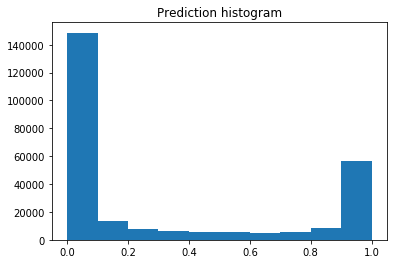

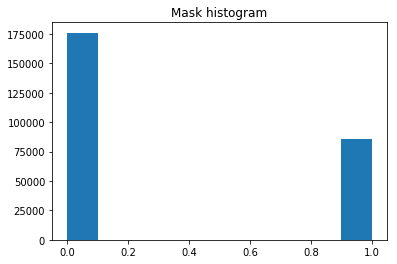

In [27]:
plt.hist(predictions[0].flatten())
plt.title("Prediction histogram")
plt.show()
plt.hist(y_test[0].flatten())
plt.title("Mask histogram")
plt.show()


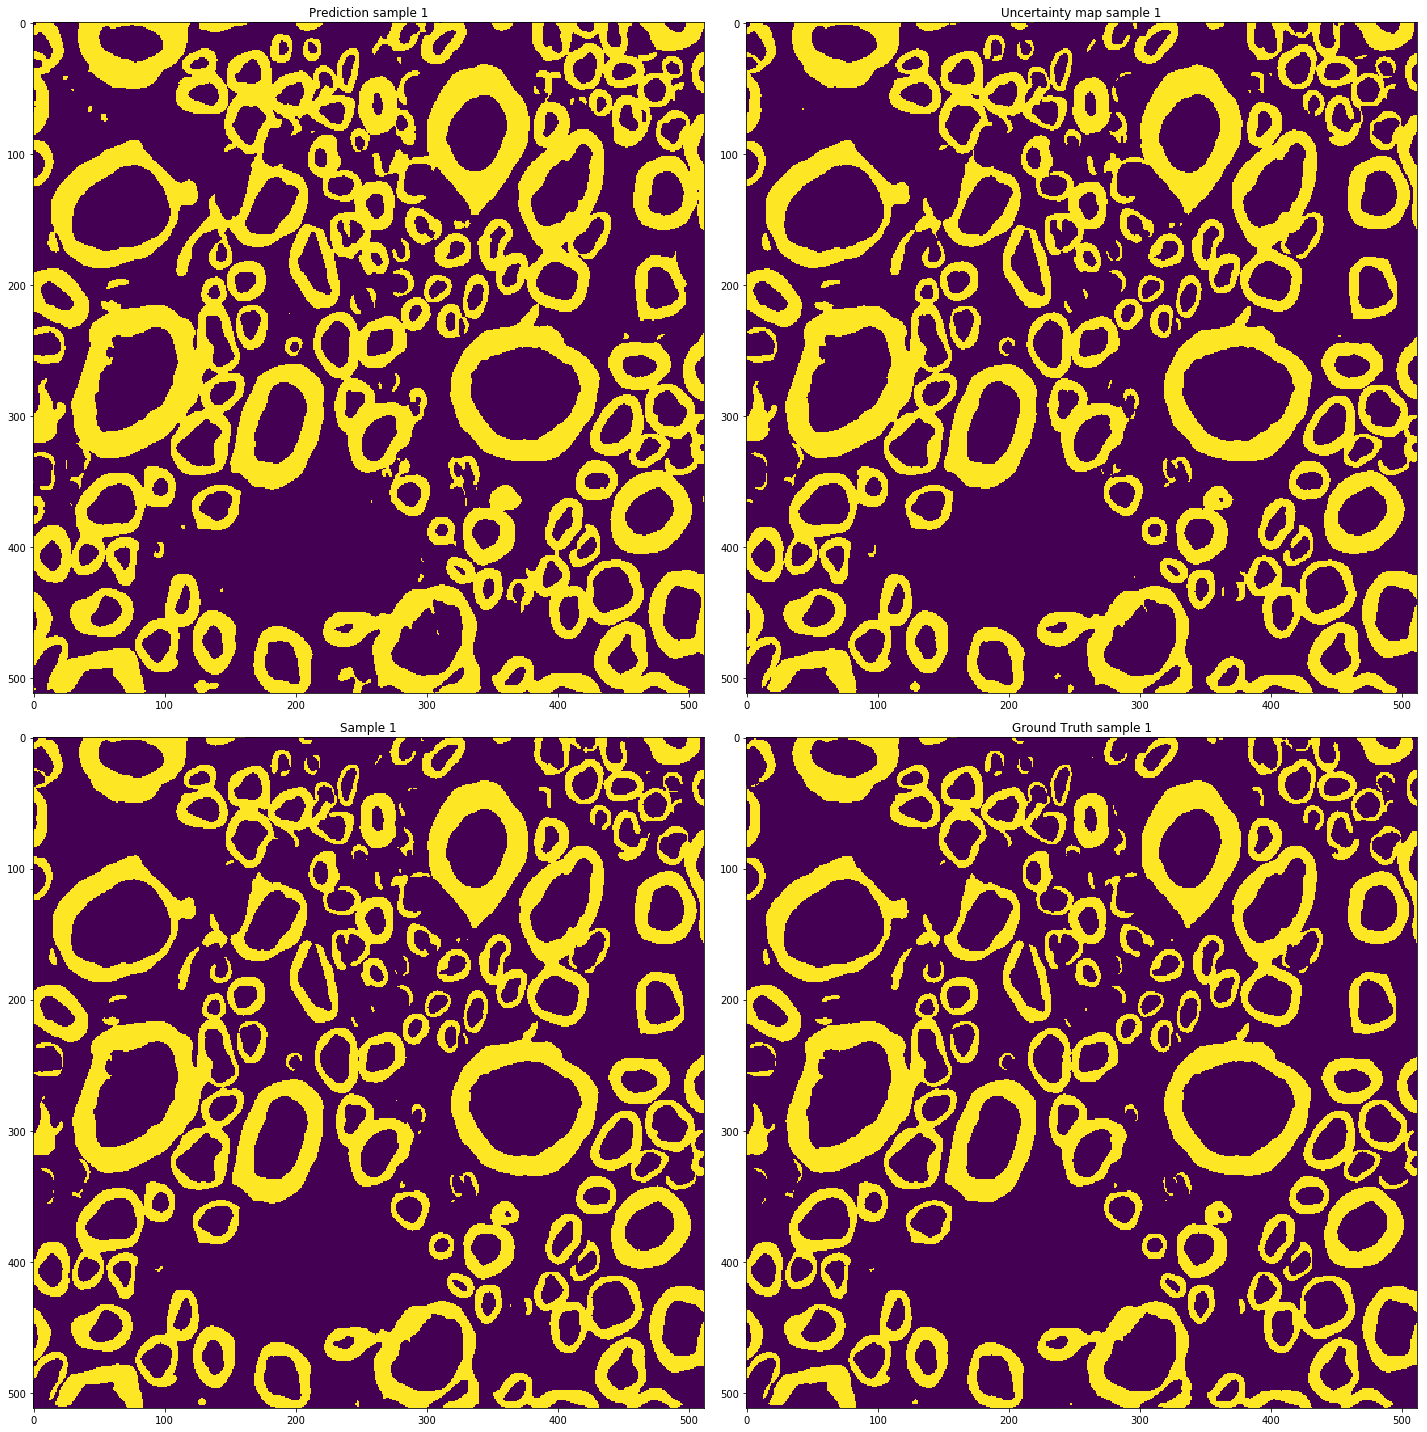

In [28]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.2, 1, cv2.THRESH_BINARY)[1])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.4, 1, cv2.THRESH_BINARY)[1])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.5, 1, cv2.THRESH_BINARY)[1])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(cv2.threshold(predictions[0][0, :, :], 0.6, 1, cv2.THRESH_BINARY)[1])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

In [24]:
final_weights_path

'./models/300epochs_good.hdf5'

In [31]:
# uncertainty computation
weights_path = "./models/300epochs_good.hdf5"
weights = weights_path
modelUncertain = unet_full_bn(dropout = True)
modelUncertain.load_weights(weights)

uncertain_map = []
uncertain = np.zeros(len(X_test))
accuracy = np.zeros(len(X_test))

print("Computing log predictions ...\n")
predictions = predict(X_test, modelUncertain)

for i in range(len(X_test)):
    sample = X_test[i].reshape([1, 1, img_rows, img_cols])
    sample_prediction = cv2.threshold(predictions[i], 0.5, 1, cv2.THRESH_BINARY)[1].astype('uint8')
    accuracy[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
    uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
    uncertain_map.append(uncertain_map_i)
    
    
uncertain_map_array = np.asarray(uncertain_map)
print(uncertain_map_array.shape)
print("Done")

Computing log predictions ...

(2, 512, 512)
Done


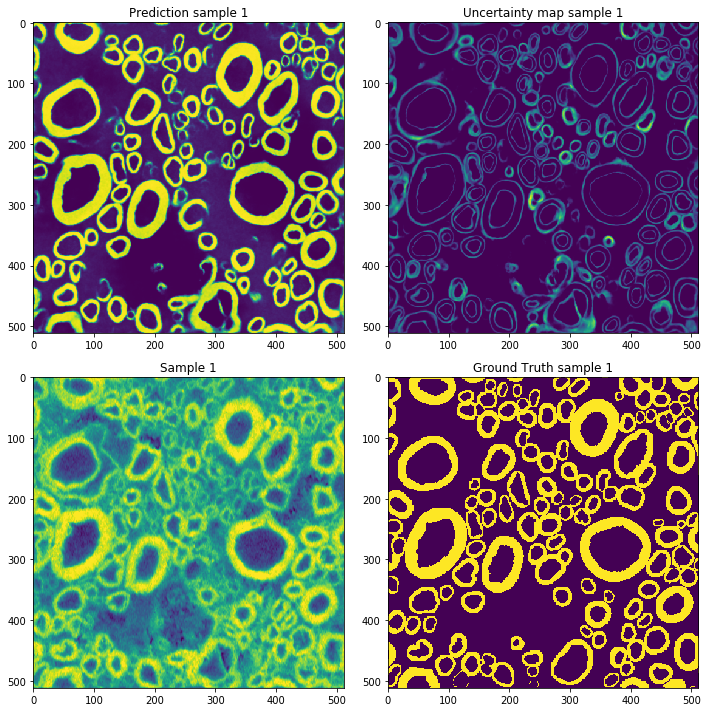

In [32]:
# Plot predictions and uncertainty map for 2 samples 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions[0][0,:,:])
plt.title("Prediction sample 1")
plt.subplot(222)
plt.imshow(uncertain_map_array[0])
plt.title("Uncertainty map sample 1")
plt.subplot(223)
plt.imshow(X_test[0][0,:,:])
plt.title("Sample 1")
plt.subplot(224)
plt.imshow(y_test[0][0,:,:])
plt.title("Ground Truth sample 1")
plt.tight_layout()
plt.show()

In [ ]:
# model 1 : bleu foncé
# 300 epochs, dropout de 0.3
model1_path = "./models/300epochs_good_less_dropout.hdf5"
# model 2 : bleu clair
# 300 epochs, dropout de 0.5
model2_path = "./models/300epochs_good.hdf5"
# model 3 : orange
# 300 epochs, dropout de 0.3, changed DA (augmented parameters)
model3_path = "./models/300epochs_good_changed_da.hdf5"

score_global = np.zeros(5)

for model_path in [model1_path, model2_path, model3_path]:
    # uncertainty computation for unlabelled

    weights = model_path
    modelUncertain = unet_full_bn(dropout = True)
    modelUncertain.load_weights(weights)



    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))

    print("Computing log predictions ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], 0.4, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        uncertain[i] = compute_uncertain(sample, sample_prediction, modelUncertain)
        uncertain_map_i = compute_uncertain_map(sample, sample_prediction, modelUncertain)
        uncertain_map.append(uncertain_map_i)


    uncertain_map_array = np.asarray(uncertain_map)
    print(uncertain_map_array.shape)
    print("Done computing predictions")

    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                    np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
